## Association subtypes emotion task

In [1]:
import seaborn as sns
import os
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [2]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [5]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_EMOTION_21-Aug-2017/';
path_association =  os.path.join(path_root,'associations/');
path_networks =  os.path.join(path_root,'networks/');

In [6]:
# List phenotypes
list_pheno  = [f for f in os.listdir(path_association)]
list_pheno = sorted(list_pheno)
list_pheno

['Cluster_1',
 'Cluster_2',
 'Cluster_3',
 'Cluster_4',
 'Cluster_5',
 'Cluster_6',
 'Cluster_7',
 'Cluster_8',
 'Cluster_9']

In [7]:
# List trials
list_trial  = [f for f in os.listdir(path_networks)]
list_trial = ['contrast_fear_vs_neut']

In [8]:
list_subtype = ['sub1','sub2','sub3','sub4','sub5']

In [9]:
# Create R-squared table to be used in R
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
        if ix == 0:
            pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
        else:
            pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)
            
    pheno_r2_final.columns = list_pheno
    pheno_r2_final.index = list_subtype
    pheno_r2_final = pd.DataFrame(pheno_r2_final)
    pheno_r2_final.to_csv(os.path.join(path_root,'{}_r2.csv'.format(trial_name)))

In [10]:
pheno_r2_final

,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
sub1,0.009049,0.006644,0.011516,0.012399,0.006744,0.006725,0.007623,0.006481,0.007847
sub2,0.016384,0.014919,0.038613,0.019635,0.010871,0.025079,0.012915,0.015710,0.030247
sub3,0.014620,0.011542,0.022714,0.018249,0.011217,0.015228,0.012251,0.011670,0.019006
sub4,0.010259,0.010677,0.029006,0.011383,0.006020,0.020051,0.007770,0.011822,0.024289
sub5,0.010824,0.010947,0.027126,0.011471,0.006608,0.021052,0.008422,0.012330,0.026600


In [11]:
# first time on terminal install cairo : "sudo apt install libcairo2-dev" then "sudo apt-get install r-cran-stringr"
#devtools::install_github("hadley/svglite")
#devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)

In [12]:
%%R
library(ggradar)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

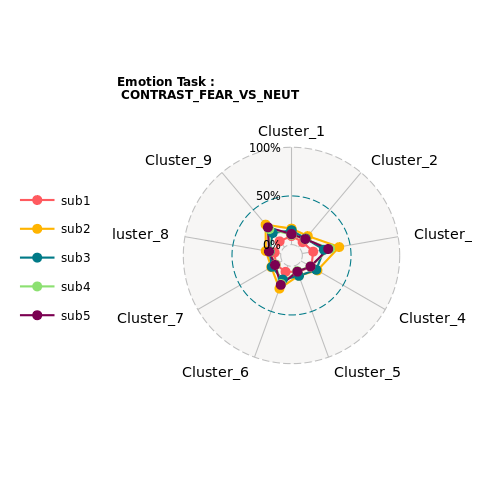

In [13]:
%%R -i path_root,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_root,ii,"_r2.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = 0,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Emotion Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_root,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

In [14]:
# plot association wieght and phenotypes
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        model_y =mat_load['model_raw']['y']
        model_x = mat_load['model_raw']['x']
        model_labels_x = mat_load['model_raw']['labels_x']
        model_labels_y = mat_load['model_raw']['labels_y']
        concat = [np.concatenate([model_y[x], model_x[x]]) for x in range(np.shape(model_y)[0])]
        model_df = pd.DataFrame(concat)
        model_df.index = model_labels_x
        colnames = np.concatenate([list_subtype,model_labels_y])
        model_df.columns = colnames
        model_df.to_csv(os.path.join(path_root,'{}_pheno_subtype.csv'.format(trial_name)))
        
        # plot association maps
        #for subtype in list_subtype:
        #    fig = plt.figure(figsize=(9,16))
        #    ax1 = fig.add_subplot(511)
        #    ax1 = sns.regplot(x=pheno_name, y=subtype, data=model_df,color="#BCB6FF");
        #    ax1.set_ylabel('{}_{}'.format(trial_name,subtype))
        #    ax1.set_xlabel(pheno_name)

In [15]:
os.path.join(path_root,'{}_pheno_subtype.csv'.format(trial_name))

'/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_EMOTION_21-Aug-2017/contrast_fear_vs_neut_pheno_subtype.csv'

## Random forest regressionn assocaition 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # read csv and manip tables 
import scipy.io #read .mat files
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,SVR,LinearSVC
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import shuffle

In [17]:
model_df = model_df.reset_index().rename(columns={'index': 'Subject'})
model_df.head()

,Subject,sub1,sub2,sub3,sub4,sub5,FD_RL,FD_scrubbed_RL,FD_LR,FD_scrubbed_LR,...,BMI,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9
0,HCP100206,0.130427,0.160363,-0.144680,-0.152580,0.176938,0.083053,0.083053,0.088776,0.088776,...,26.64,1.285200,1.430662,0.090595,-0.511867,0.708044,-0.311561,1.976455,-0.221303,0.571492
1,HCP100307,-0.112971,-0.527071,0.228735,0.521636,-0.504117,0.102121,0.102121,0.090372,0.090372,...,22.96,0.523454,-0.714056,-0.663549,-0.142587,-0.559104,-0.582609,-0.704316,-0.792560,0.421945
2,HCP100408,0.288800,0.655515,-0.444047,-0.529346,0.533747,0.113475,0.113475,0.133985,0.133985,...,27.75,0.092377,-0.034456,1.070145,0.219718,-0.108636,0.026297,-0.590364,-0.167300,-0.049222
3,HCP100610,0.130245,-0.103275,-0.051848,0.199100,-0.226368,0.158172,0.158172,0.174523,0.166174,...,36.91,-0.361653,-0.387092,0.813155,-0.198723,-0.575019,1.430869,0.201677,-0.631634,0.770983
4,HCP101006,0.028481,0.064732,-0.022562,-0.082704,0.078553,0.132186,0.132186,0.117849,0.117849,...,30.27,0.037814,-0.884476,0.444130,-0.310122,-0.382892,-0.364271,-0.755113,0.459547,-0.740855


In [18]:
 # import all pheno data
all_pheno = pd.read_csv(os.path.join('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan_norm.csv'))

In [19]:
# set subject names with Prefix HCP
all_pheno.rename(columns={'Unnamed: 0': 'Subject'},inplace=True)
all_pheno['Subject'] = 'HCP'+ all_pheno['Subject'].astype(str)
all_pheno.head()

,Subject,Handedness,BMI,BPSystolic,BPDiastolic,PSQI_Score,PicSeq_Unadj,CardSort_Unadj,Flanker_Unadj,PMAT24_A_CR,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,HCP100004,0.654367,-0.262795,0.706508,-0.038133,0.912634,0.543120,-1.133786,0.964184,0.526831,...,-0.560257,-0.137093,0.904230,0.582300,0.871791,-0.430821,-0.682838,1.605890,-0.312732,1.863197
1,HCP100206,-0.008896,-0.057218,-0.392537,-0.584901,0.249934,1.010833,0.415954,1.810203,0.732102,...,0.600528,1.133355,2.036441,1.148677,2.255963,1.506107,2.573747,2.101592,1.602519,0.819628
2,HCP100307,0.654367,-0.715064,-0.529918,-0.676029,-0.744115,-0.050883,0.863311,0.022050,0.116291,...,-0.560257,-0.681571,-0.888437,-0.323905,-0.685403,-0.624514,-0.682838,-0.707386,-0.660960,-0.432656
3,HCP100408,-0.229983,0.141209,1.874244,1.511043,-0.081415,1.057825,-0.360372,0.885089,-1.936414,...,0.407063,-0.681571,-0.982788,-0.210629,-0.685403,-0.430821,-0.682838,-0.707386,-0.660960,-0.432656
4,HCP100610,0.433279,1.778676,1.118650,-0.220389,-0.081415,-0.166160,1.454289,1.420734,1.347913,...,-0.753721,-0.137093,0.432475,-0.323905,-0.685403,-0.624514,-0.682838,2.597294,-0.835073,-0.641370


In [20]:
# Merge al pheno with subttyp weights
all_pheno_pruned = pd.merge(model_df[['Subject','sub1','sub2','sub3','sub4','sub5','FD_scrubbed_mean']],all_pheno,on='Subject',how='left')
# Drop NaN
all_pheno_pruned.dropna(inplace=True)

In [25]:
# Set data X Y
data_X = all_pheno_pruned.drop(['Subject','sub1','sub2','sub3','sub4','sub5'],axis=1)
#mask = feature_importances >= np.percentile(mean_feimp,feimp_thresh)
#data_X = data_X[data_X.columns[mask]]
data_Y = all_pheno_pruned['sub2']
y = data_Y.values
scl = StandardScaler()
y = scl.fit_transform(y.reshape(-1, 1))

minmiax = MinMaxScaler(feature_range=(-1, 1))
y = minmiax.fit_transform(y)[:,0]

x =data_X.values
scl = StandardScaler()
x = scl.fit_transform(x)

x, y = shuffle(x, y, random_state=0)
# print shape
print('y shape:',y.shape)
print('x shape:',x.shape)

y shape: (778,)
x shape: (778, 67)


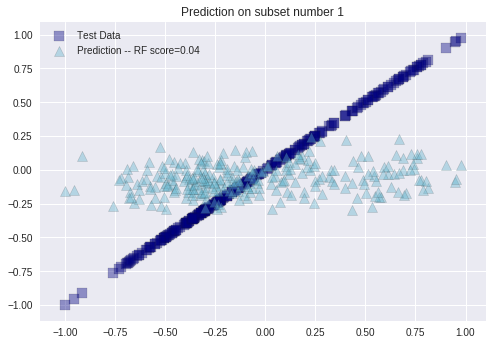

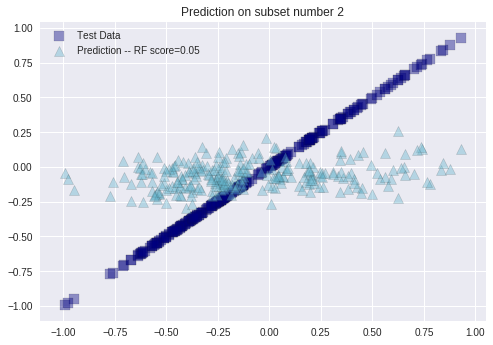

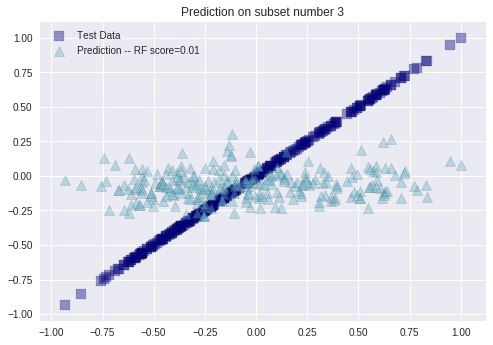

Mean R-squared : 0.0312145685955


In [26]:
# apply machine learning : Random forest regression
rfr = RandomForestRegressor(n_estimators=500,oob_score=True,n_jobs=-1)
skf = KFold(n_splits=3)
feimp_l = np.zeros((skf.n_splits,x.shape[1]))
scores = np.zeros((skf.n_splits,1))
std =  np.zeros((skf.n_splits,x.shape[1]))
c = 0
for train_index, test_index in skf.split(x):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfr.fit(x_train, y_train)
    pred = rfr.predict(x_test)
    
    rsq = rfr.score(x_test, y_test)
    scores[c,:] = rsq
    
    feimp = rfr.feature_importances_
    feimp_l[c,:] = feimp[:]
    
    std[c,:] = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
    
    c+=1
    # Plot prediction
    #plt.figure()
    #plt.scatter(y_test,y_test,label='Test data')
    #plt.scatter(y_test,pred,label= 'Predicted data')
    #plt.title('R-squared :{}'.format(rsq))
    #print('R-squared :',rsq)
    #plt.plot(y_test, y_test,'bo', label='Test data')
    #plt.plot(y_test, pred, 'co', label='Predicted data')
    #plt.title('R-squared :{}'.format(rsq))
    #plt.legend()
    #plt.show()
    s = 100
    a = 0.4
    plt.figure()
    plt.scatter(y_test, y_test, edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Test Data")

    plt.scatter(y_test, pred, edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="Prediction -- RF score=%.2f" % rsq)
    plt.title("Prediction on subset number {}".format(c))
    plt.legend()
    plt.show()
print('Mean R-squared :',scores.mean())

In [31]:
# Threshold future importance
feimp_thresh = 20 # Percentile of future to be removed
mean_feimp = np.mean(feimp_l, axis=0)
mean_std = np.mean(std, axis=0)
feature_importances = pd.Series(mean_feimp,index= data_X.columns)
feature_importances_select = feature_importances[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
std_select = mean_std[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
indices = np.argsort(mean_feimp[feature_importances >= np.percentile(mean_feimp,feimp_thresh)])[::-1]

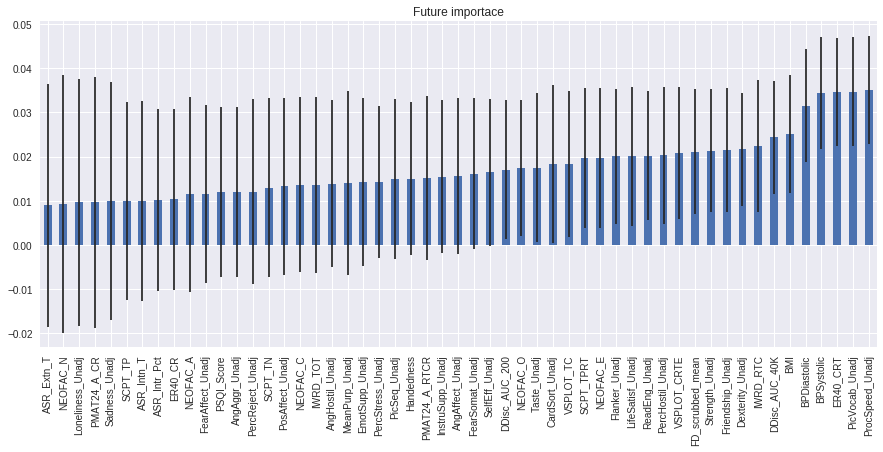

In [32]:
# Plot Future importance
feature_importances_select.sort()
feature_importances_select.plot(kind='bar',yerr=std_select[indices],figsize=(15,6),title='Future importace')